<a href="https://colab.research.google.com/github/HaywhyCoder/SentimentAnalysis-AmazonProductReview/blob/main/Sentiment_Analysis_Amazon_product_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Amazon Product Review Sentiment Analysis

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mahmudulhaqueshawon/amazon-product-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/amazon-product-reviews


#### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

#### Load the Dataset

In [ ]:
data = pd.read_csv('/root/.cache/kagglehub/datasets/mahmudulhaqueshawon/amazon-product-reviews/versions/1/amazon.csv')
data.shape

(19996, 2)

In [ ]:
data[data['label'] == 0][:5]

,Text,label
78,They call it three next mario??? Are the 'prof...,0
79,Angry People in my book! Any moron who would ...,0
80,Argry Birds is for free to play a games on you...,0
81,cant stand this game. love the concept and pla...,0
82,Don't really know the point of this game. It'...,0


In [ ]:
data = data.sample(n=2500, random_state=42) # sample 2500 sentences from the dataset
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Create huggingface dataset
datasets = DatasetDict({
    'train': Dataset.from_pandas(train_data),
    'test': Dataset.from_pandas(test_data)})

#### Load the Pre-Trained Model

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=2,
                                                      id2label={1: 'Positive', 0: 'Negative'},
                                                      label2id = {'Positive': 1, 'Negative': 0})

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(row):
  return tokenizer(row['Text'], padding='max_length', truncation=True, return_tensors='pt')

tokenized_datasets = datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(pred):
  preds, labels = pred
  preds = np.argmax(preds, axis=1)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
  accuracy = accuracy_score(labels, preds)
  return {
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1': f1
  }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    warmup_steps=500,
    weight_decay=.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss
10,0.940100
20,0.872500
30,0.720200
40,0.613900
50,0.564500
60,0.540600
70,0.572300
80,0.537600
90,0.502100
100,0.534200


TrainOutput(global_step=250, training_loss=0.43209842944145205, metrics={'train_runtime': 186.0425, 'train_samples_per_second': 10.75, 'train_steps_per_second': 1.344, 'total_flos': 526222110720000.0, 'train_loss': 0.43209842944145205, 'epoch': 1.0})

#### Evaluate the model

In [ ]:
eval_results = trainer.evaluate()

for key, value in eval_results.items():
  print(f"{key}: {value}")

eval_loss: 0.2529016435146332
eval_accuracy: 0.92
eval_precision: 0.9441489361702128
eval_recall: 0.9491978609625669
eval_f1: 0.9466666666666667
eval_runtime: 13.4735
eval_samples_per_second: 37.11
eval_steps_per_second: 4.676
epoch: 1.0


In [ ]:
y_pred = trainer.predict(tokenized_datasets['test'])
y_pred = np.argmax(y_pred[0], axis = 1)

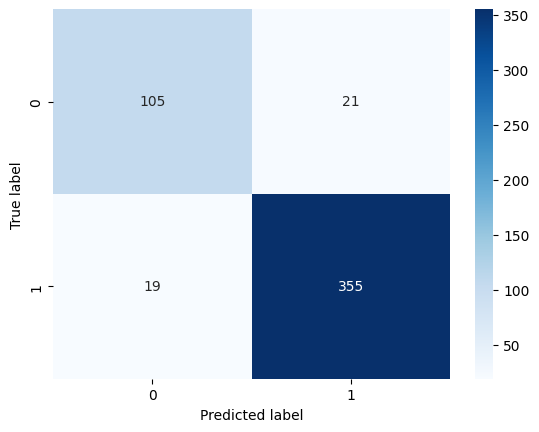

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cf_matrix = confusion_matrix(tokenized_datasets['test']['label'], y_pred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

The model has an accuracy of 92% on test data. The confusion matrix shows the model can correctly identify the classes in the text. The confusion matrix is further supported by the precision and recall scores, showing the model performs well both on prediction and identification of the classes. Overall, the f1 score of 0.95 shows that the model is reliable.